This code loads the Turbofan dataset, and fits a random forest and balanced random forest, with basic hyperparameters optimization and arbitrary choice of metrics, on training set and on hold-out set. The dataset is roughly and arbitrarily cleaned. The stratification is not done properly. The codebase is almost the same as in the imbalanced_public_dataset notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification

from sklearn.decomposition import PCA

from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

from collections import Counter

rng = np.random.RandomState(0)



In [38]:
def print_class_distribution(y):
    labels = np.unique(y)
    class_distrib = Counter(y).most_common(len(labels))
    print(f"classes distribution {class_distrib}")

def fetch_data():

    # very crude data reading and processing.
    # the stratification strategy used in other functions should take into account the equipment ID which is the first column
    # instead we drop it

    dataset_local = "train_FD001.txt"
    data_df = pd.read_csv(dataset_local, sep=" ", header=None)
    
    # target = will fail in the next 5 steps
    X_to_process = data_df.to_numpy()
    size = X_to_process.shape[0]
    y= np.zeros(size)
    cur_eq_id = 0.0
    for i in range(size):
        line = X_to_process[i]
        eq_id = line[0]
        if (eq_id != cur_eq_id):
            y[i-4]=1
            y[i-3]=1
            y[i-2]=1
            y[i-1]=1
            y[i]=1
        cur_eq_id = eq_id
    y[0]=0
    
    # set N/A to 0, drop first column (equipment ID) and keep values
    X = data_df.drop(data_df.columns[0], axis=1).fillna(0).to_numpy()
    print(f"X shape {X.shape}")
    print(f"y shape {y.shape}")
    
    print_class_distribution(y)
    
    return X, y

X, y = fetch_data()


X shape (20631, 27)
y shape (20631,)
classes distribution [(0.0, 20132), (1.0, 499)]


PCA: Top 2 components explain 98% of variance


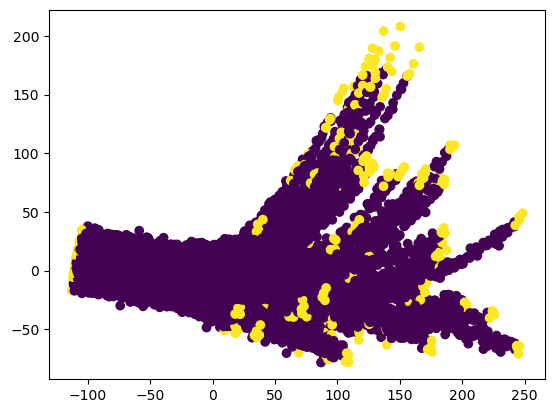

In [34]:
if (X.shape[1]!=2):
    # if more than 2 dimensions
    # make a PCA and plot 2 top components
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)

    total_var = pca.explained_variance_ratio_.sum() * 100
    print(f"PCA: Top 2 components explain {total_var:.0f}% of variance")

    plt.scatter(components[:,0],components[:,1],c=y)
else:
    # otherwise simply plot 2d data as scatter plot
    plt.scatter(X[:,0],X[:,1],c=y)


In [35]:
# metrics routine

def metrics(X, y, clf):
    y_hat = clf.predict(X)
    # return fbeta_score(y, y_hat, beta=2)
    return balanced_accuracy_score(y, y_hat)

def get_grid():
    # Hyperparameter tuning (HPT) function for the Random Forest and Balanced Random Forest

    # Define the parameter grid

    # Number of trees in random forest
    n_estimators = [10,20,100]
    # Maximum number of levels in tree
    max_depth = [3,10,20]
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    return random_grid
    
# training routine
def classify(X, y, clf):

    grid = get_grid()

    rs_strat = RandomizedSearchCV(estimator = clf, param_distributions = grid, 
                                scoring = 'balanced_accuracy', n_iter = 20, 
                                cv = StratifiedKFold(n_splits=5),
                                verbose=0, random_state=rng, n_jobs = -1)
    rs_strat.fit(X, y)
    best_params = rs_strat.best_params_
    best_estimator = rs_strat.best_estimator_
    best_score = rs_strat.best_score_ 
    return (best_estimator, best_score)

            
    

In [36]:

# Applies clf without touching the data.
def dummy_clf(x, y, clf):
    return (x.shape[0], classify(x, y, clf))

# Applies Random Undersampling
def under_sampler(x, y, clf):
    rus = RandomUnderSampler(random_state=rng)
    rx, ry = rus.fit_resample(x, y)
    return (rx.shape[0], classify(rx, ry, clf))

# Applies Random Undersampling
def over_sampler(x, y, clf):
    ros = RandomOverSampler(random_state=rng)
    rx, ry = ros.fit_resample(x, y)
    return (rx.shape[0], classify(rx, ry, clf))

# Applies Synthetic Data Augmentation through SMOTE
def smote(x, y, clf):
    smote= SMOTE(random_state=rng)
    rx, ry = smote.fit_resample(x, y)
    return (rx.shape[0], classify(rx, ry, clf))

In [37]:
# experiment!

# we have X and y, let's get the hold out
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.20, random_state=rng, stratify=y)

print_class_distribution(y_hold)

# these are all the classifiers we want to test
clfs = []
clfs.append(RandomForestClassifier(random_state=rng))
clfs.append(BalancedRandomForestClassifier(random_state=rng))
    
size_hold_out = X_hold.shape[0]

for clf in clfs:
    print(f"Model            t_bac t_size\
    h_bac h_size")
    #
    (size_train, (best_clf, metrics_train)) = dummy_clf(X_train, y_train, clf)
    metrics_hold_out = metrics(X_hold, y_hold, best_clf)
    print(f"{str(clf)[0:10]} dummy {metrics_train:.3f} {size_train:>5d} \
    {metrics_hold_out:.3f} {size_hold_out:>5d}")
    #
    (size_train, (best_clf, metrics_train)) = under_sampler(X_train, y_train, clf)
    metrics_hold_out = metrics(X_hold, y_hold, best_clf)
    print(f"{str(clf)[0:10]} under {metrics_train:.3f} {size_train:>5d} \
    {metrics_hold_out:.3f} {size_hold_out:>5d}")
    #
    (size_train, (best_clf, metrics_train)) = over_sampler(X_train, y_train, clf)
    metrics_hold_out = metrics(X_hold, y_hold, best_clf)
    print(f"{str(clf)[0:10]} over  {metrics_train:.3f} {size_train:>5d} \
    {metrics_hold_out:.3f} {size_hold_out:>5d}")
    #
    (size_train, (best_clf, metrics_train)) = smote(X_train, y_train, clf)
    metrics_hold_out = metrics(X_hold, y_hold, best_clf)
    print(f"{str(clf)[0:10]} smote {metrics_train:.3f} {size_train:>5d} \
    {metrics_hold_out:.3f} {size_hold_out:>5d}")


classes distribution [(0.0, 4027), (1.0, 100)]
Model            t_bac t_size    h_bac h_size
RandomFore dummy 0.835 16504     0.838  4127
RandomFore under 0.977   798     0.971  4127
RandomFore over  0.995 32210     0.825  4127
RandomFore smote 0.993 32210     0.893  4127
Model            t_bac t_size    h_bac h_size
BalancedRa dummy 0.974 16504     0.977  4127
BalancedRa under 0.970   798     0.975  4127
BalancedRa over  0.996 32210     0.826  4127
BalancedRa smote 0.994 32210     0.877  4127
